## Process Optimization - the `Main` code 

### First Batch of Bayesian Optimization based on Experimental Data produced on Sep 22, 2020
- This notebook is to run Bayesian Optimization on initial sampling data, and provide the first batch suggestion on experiment conditions
- Experiments of perovskite devices are prepared by Nick Rolston and Thomas Colburn (Stanfrod University) 
- Jupyter Notebook is prepared by Zhe Liu (Massachusetts Insititute of Technology)

In [1]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Load the experimental film data

In [2]:
########## Read in excel file ##########

# df_film = pd.read_excel('/Users/matt/Desktop/RAPID optimization/SL-PerovskiteOpt/ML_perovskite_data.xlsx', sheet_name='PVK Data')
df_film = pd.read_excel(
    "/groups/aprintz/github/SL-PerovskiteOpt/RAPID Optimization/ML_perovskite_data.xlsx",
    sheet_name="PVK Data",
)

df_film.columns = [
    "ML Condition",
    "Molarity [M]",
    "Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "volume used [uL]",
    "Confinement gap [um]",
    "% DMSO",
    "Temp Substrate [\N{DEGREE SIGN}C]",
    "Post Anneal time [m]",
    "Success or Fail",
    "Notes",
    "Where to find",
]
########## Get successful processing conditions ##########

success_conditions = df_film[df_film["Success or Fail"] == 1]["ML Condition"].values

########## Define processing variables to include ##########

included_vars = [
    "Molarity [M]",
    "Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "Confinement gap [um]",
    "% DMSO",
    "Temp Substrate [\N{DEGREE SIGN}C]",
    "Post Anneal time [m]",
]

########## Define new dataframe with only included processing variables ##########

df_included_vars = df_film[included_vars]
df_included_vars


,Molarity [M],Temperature [°C],Speed [m/min],Confinement gap [um],% DMSO,Temp Substrate [°C],Post Anneal time [m]
0,0.4,100,1.0,100,10,150,5
1,0.4,100,0.5,100,10,150,5
2,0.4,100,1.0,100,20,150,5
3,0.4,100,0.5,100,20,150,5
4,0.4,100,1.0,100,30,150,5
...,...,...,...,...,...,...,...
103,1.2,100,0.5,100,40,150,5
104,1.2,100,1.0,100,60,150,5
105,1.2,100,0.5,100,60,150,5
106,1.2,100,1.0,100,80,150,5


# Set the variable space of process conditions

In [3]:
import numpy as np

precursor_min, precursor_max, precursor_step = [0.4, 2, 0.2]  # Unit: concentration 
precursor_var = np.arange(precursor_min, precursor_max + precursor_step, precursor_step)
precursor_num = len(precursor_var)

super_temp_min, super_temp_max, super_temp_step = [50, 200, 25]  ## Unit: degC
super_temp_var = np.arange(super_temp_min, super_temp_max + super_temp_step, super_temp_step)
super_temp_num = len(super_temp_var)

speed_min, speed_max, speed_step = [0.5, 3, 0.5]  ## Unit: m/min 
speed_var = np.arange(speed_min, speed_max + speed_step, speed_step)
speed_num = len(speed_var)

dist_min, dist_max, dist_step = [25, 200, 25]  ## Unit: microns 
dist_var = np.arange(dist_min, dist_max + dist_step, dist_step)
dist_num = len(dist_var)

dmso_min, dmso_max, dmso_step = [0, 100, 10]  # Unit: %DMSO
dmso_var = np.arange(dmso_min, dmso_max + dmso_step, dmso_step)
dmso_num = len(dmso_var)

sub_temp_min, sub_temp_max, sub_temp_step = [50, 200, 25]  ## Unit: degC 
sub_temp_var = np.arange(sub_temp_min, sub_temp_max + sub_temp_step, sub_temp_step)
sub_temp_num = len(sub_temp_var)

anneal_min, anneal_max, anneal_step = [0, 10, 2.5]  ## Unit: Minutes
anneal_var = np.arange(anneal_min, anneal_max + anneal_step, anneal_step)
anneal_num = len(anneal_var)

########## Create process variable array ##########
var_array = [
    precursor_var,
    super_temp_var,
    speed_var,
    dist_var,
    dmso_var,
    sub_temp_var,
    anneal_var,
]

########## Create labels for process variable array, making sure order is same as var_array ##########
x_labels = [
    "Precursor Concentration [M]",
    "Superstrate Temperature [\N{DEGREE SIGN}C]",
    "Speed [m/min]",
    "Working Distance [\N{greek small letter mu}m]",
    "DMSO Concentration [%v/v]",
    "Substrate Temperature [\N{DEGREE SIGN}C]",
    "Post Annealing Time [min]"
]

# print(var_array)

### Define Emukit variable space from above processing conditions. Only edit if variables added/removed. Make sure the order and number of variables is consistent!

In [4]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter

parameter_space = ParameterSpace([ContinuousParameter('Precursor', 0, 1),
                                 ContinuousParameter('SuperTemp', 0, 1),
                                 ContinuousParameter('Speed', 0, 1),
                                 ContinuousParameter('Dist', 0, 1),
                                 ContinuousParameter('DMSO', 0, 1),
                                 ContinuousParameter('SubTemp', 0, 1),
                                 ContinuousParameter('Anneal', 0, 1),
                                 ])

def x_normalizer(X):

    def max_min_scaler(x, x_max, x_min):
        return (x - x_min) / (x_max - x_min)

    x_norm = []
    for x in X:
        x_norm.append(
            [
                max_min_scaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_norm)


def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x * (x_max - x_min) + x_min

    x_original = []
    for x in x_norm:
        x_original.append(
            [
                max_min_rescaler(x[i], max(var_array[i]), min(var_array[i]))
                for i in range(len(x))
            ]
        )
    return np.array(x_original)


def get_closest_array(suggested_x):

    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value: abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value

    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append(
            [get_closest_value(x[i], var_list[i]) for i in range(len(x))]
        )
    return np.array(modified_array)

### Run GP Classification on the Experimental Data using GPy
- Experimental film data for round 0 initial sampling: binary film quality

### https://gpy.readthedocs.io/en/deploy/GPy.models.html#module-GPy.models.gp_classification
### https://notebook.community/SheffieldML/notebook/GPy/basic_classification

In [5]:
from emukit.core.interfaces import IModel
from typing import Tuple

x_init = x_normalizer(df_included_vars.to_numpy()) # Normalize experimental data
y_init = np.transpose([df_film["Success or Fail"].to_numpy()]) # Get array of pass/fail conditions
X, Y = [x_init, y_init] # Rename variables to statistics standard

input_dim = len(X[0])  # Get number of variables in data

class SklearnGPModel(IModel):
    def __init__(self, sklearn_model):
        self.model = sklearn_model

    def predict(self, X):
        probs, f_mu, f_var = self.model.predict_proba(X)
        # return f_mu, f_var
        return f_mu.reshape(len(f_mu), 1), f_var.reshape(len(f_var), 1)
        # return f_mu.ravel(), f_var.ravel()
    
    def predict_proba(self, X):
        probs, f_mu, f_var = self.model.predict_proba(X)
        return probs
    
    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        self.model.fit(X, Y)

    def optimize(self, verbose: bool = False) -> None:
        # There is no separate optimization routine for sklearn models
        pass
    
    @property
    def X(self) -> np.ndarray:
        # return self.model.X_train_.ravel()
        return self.model.X_train_

    @property
    def Y(self) -> np.ndarray:
        return self.model.y_train_.reshape(len(self.model.y_train_), 1)
        # return self.model.y_train_.ravel()

### Predict binary success/fail using classifier

 /home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000000.0. Increasing the bound and calling fit again may find a better value.
 /home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning:The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 1000000.0. Increasing the bound and calling fit again may find a better value.
 /home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning:The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 1000000.0. Increasing the bound and calling fit again may find a better value.
 /home/u4/pjlohr/.conda/envs/bayes_opt_3

all rmse: 0.3428
all R^2: 0.5165
all spearman: 0.7067


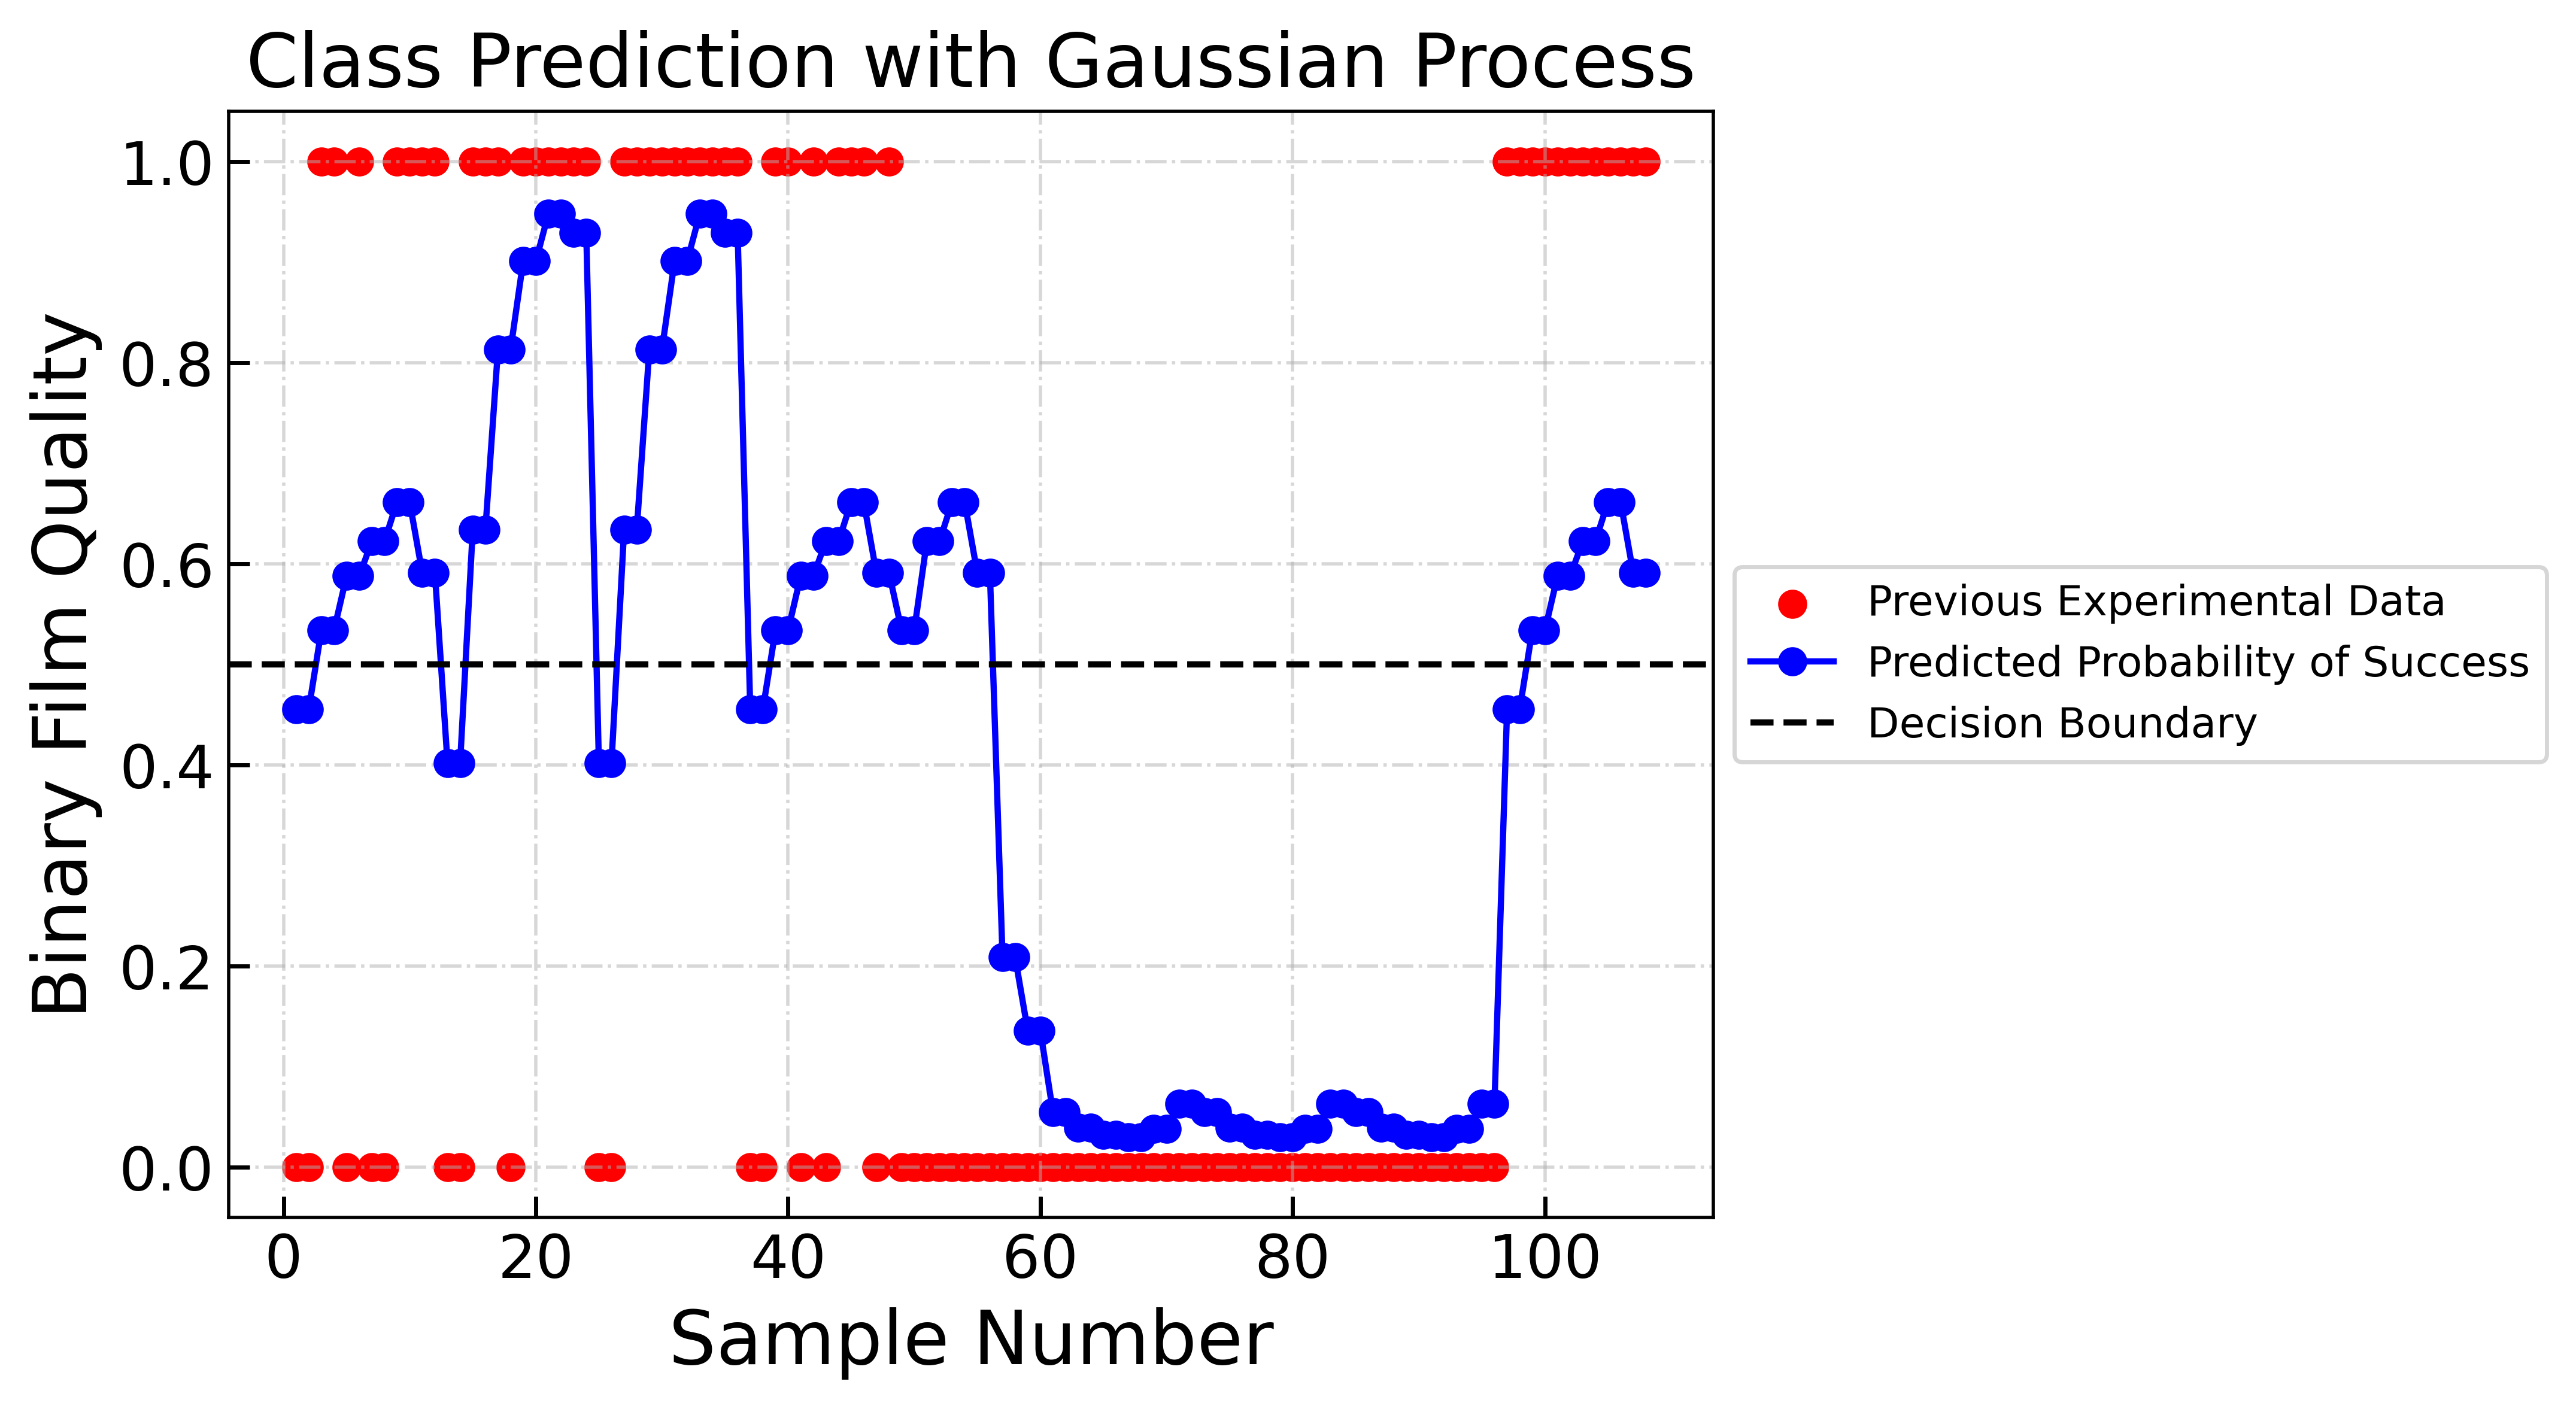

In [6]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

x_init = x_normalizer(df_included_vars.to_numpy()) # Normalize experimental data 
y_init = np.transpose([df_film["Success or Fail"].to_numpy()]) # Get array of pass/fail conditions
X, Y = [x_init, y_init.ravel()] # Flatten output dimensions to (N,) and convert variables to statistics standard Y(X)

input_dim = len(X[0])  # Get number of variables in space

# kernel = 1.0 * RBF(length_scale=np.ones(input_dim),
#                         length_scale_bounds=(1e-2, 1e5))
kernel = 1.0 * Matern(nu=2.5, 
                      length_scale=np.ones(input_dim),
                        length_scale_bounds=(1e-2, 1e6))

prior_model = GaussianProcessClassifier(kernel=kernel,
                                  copy_X_train=True,
                                  random_state=42,
                                  n_restarts_optimizer=25,
                                  n_jobs=-1
                                  )
prior_model.fit(X,Y)
prior_model.kernel_
probs, f_mu, f_var = prior_model.predict_proba(X)

# classes = prior_model.predict(X)
# print(classes[0], type(classes[0]))

y_pred = probs[:,1]

fontsize = 18
lims = (-0.1, 1.1)

# Plot the true input data and the prediction against the data point number
plt.figure(dpi=500)
# plt.plot(range(1, len(Y) + 1), Y, "ro-", label="True Data")
plt.scatter(range(1, len(Y) + 1), Y, marker='o', color='r', label="Previous Experimental Data")
plt.plot(range(1, len(Y) + 1), y_pred, "bo-", label="Predicted Probability of Success")
# plt.scatter(range(1, len(Y) + 1), y_pred, marker='o', color='b', label="Predicted Probability of Success")
plt.axhline(y=0.5, c='black', linestyle='dashed', label="Decision Boundary")

title = "Class Prediction with Gaussian Process"
plt.xlabel("Sample Number", fontsize=fontsize)
plt.ylabel("Binary Film Quality", fontsize=fontsize)
plt.title(title, fontsize=fontsize)
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(
    direction="in", length=5, width=1, labelsize=fontsize * 0.8, grid_alpha=0.5
)
plt.grid(True, linestyle="-.")

mse = mean_squared_error
mse_all = mse(Y, y_pred)
print("all rmse: %.4f" % (np.sqrt(mse_all)))

rsquared_all = r2_score(Y, y_pred)
print("all R^2: %.4f" % (rsquared_all))

sprman_all = spearmanr(Y, y_pred)
print("all spearman: %.4f" % (sprman_all[0]))


In [7]:
# emukit_model = SklearnGPModel(model)
# test_x = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]]
# probs = emukit_model.predict_proba(test_x)

# print(probs)

# Bayesian Optimization 

### Select acquisition function

In [8]:
# from typing import Tuple, Union
# import numpy as np
# from emukit.core.acquisition import Acquisition
# from emukit.core.interfaces import IDifferentiable, IModel
# from scipy.special import owens_t

# class NegativeLowerConfidenceBound_Phi(Acquisition):
#     def __init__(self, model: Union[IModel, IDifferentiable], beta: float = 1.0) -> None:
#         """
#         This acquisition computes the negative lower confidence bound for a given input point. This is the same
#         as optimizing the upper confidence bound if we would maximize instead of minimizing the objective function.
#         For information as well as some theoretical insights see:

#         Gaussian Process Optimization in the Bandit Setting: No Regret and Experimental Design
#         Niranjan Srinivas, Andreas Krause, Sham Kakade, Matthias Seeger
#         In Proceedings of the 27th International Conference  on  Machine  Learning

#         :param model: The underlying model that provides the predictive mean and variance for the given test points
#         :param beta: Is multiplied on the standard deviation to control exploration / exploitation
#         """
#         self.model = model
#         self.beta = beta

#     def evaluate(self, x: np.ndarray) -> np.ndarray:
#         """
#         Computes the negative lower confidence bound

#         :param x: points where the acquisition is evaluated.
#         """
#         f_fmu, f_var = self.model.predict(x)
        
#         z1 = f_mu / np.sqrt(1 + f_var)
#         z2 = 1.0 / np.sqrt(1 + 2*f_var)
#         E = GPy.likelihoods.Bernoulli().gp_link.transf(z1)
#         V = E - 2*owens_t(z1, z2) - E**2
#         std_dev = np.sqrt(V)
        
#         return -(E - self.beta * std_dev)

#     def evaluate_with_gradients(self, x: np.ndarray) -> Tuple:
#         """
#         Computes the negative lower confidence bound and its derivative

#         :param x: points where the acquisition is evaluated.
#         """
#         mean, variance = self.model.predict(x)
#         standard_deviation = np.sqrt(variance)

#         dmean_dx, dvariance_dx = self.model.get_prediction_gradients(x)
#         dstandard_deviation_dx = dvariance_dx / (2 * standard_deviation)

#         lcb = -(mean - self.beta * standard_deviation)

#         dlcb_dx = -(dmean_dx - self.beta * dstandard_deviation_dx)

#         return lcb, dlcb_dx

#     @property
#     def has_gradients(self):
#         return isinstance(self.model, IDifferentiable)

In [9]:
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces.models import IModel
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.candidate_point_calculators import GreedyBatchPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization import AcquisitionOptimizerBase, GradientAcquisitionOptimizer
from emukit.core.parameter_space import ParameterSpace
from emukit.experimental_design.acquisitions import ModelVariance
from emukit.core.loop import CandidatePointCalculator
from emukit.core.loop import LoopState
import numpy as np

class GreedyBatchPointCalculator(CandidatePointCalculator):
    """
    Batch point calculator. This point calculator calculates the first point in the batch then adds this as a fake
    observation in the model with a Y value equal to the mean prediction. The model is reset with the original data at
    the end of collecting a batch but if you use a model where training the model with the same data leads to different
    predictions, the model behaviour will be modified.
    """

    def __init__(
        self,
        model: IModel,
        acquisition: Acquisition,
        acquisition_optimizer: AcquisitionOptimizerBase,
        batch_size: int = 1,
    ):
        """
        :param model: Model that is used by the acquisition function
        :param acquisition: Acquisition to be optimized to find each point in batch
        :param acquisition_optimizer: Acquisition optimizer that optimizes acquisition function
                                      to find each point in batch
        :param batch_size: Number of points to calculate in batch
        """
        if (not isinstance(batch_size, int)) or (batch_size < 1):
            raise ValueError("Batch size should be a positive integer")
        self.model = model
        self.acquisition = acquisition
        self.acquisition_optimizer = acquisition_optimizer
        self.batch_size = batch_size

    def compute_next_points(self, loop_state: LoopState, context: dict = None) -> np.ndarray:
        """
        :param loop_state: Object containing history of the loop
        :param context: Contains variables to fix through optimization of acquisition function. The dictionary key is
                        the parameter name and the value is the value to fix the parameter to.
        :return: 2d array of size (batch_size x input dimensions) of new points to evaluate
        """
        self.acquisition.update_parameters()
        new_xs = []
        original_data = (self.model.X, self.model.Y)
        for _ in range(self.batch_size):
            new_x, _ = self.acquisition_optimizer.optimize(self.acquisition, context)
            new_xs.append(new_x)
            new_y = self.model.predict(new_x)[0]
            
            new_y = np.where(new_y > 0, np.int64(1), np.int64(0))
            
            # Add new point as fake observation in model
            all_x = np.concatenate([self.model.X, new_x], axis=0)
            all_y = np.concatenate([self.model.Y, new_y], axis=0)
            # print(all_x, all_y)

            self.model.set_data(all_x, all_y)
        # Reset data
        self.model.set_data(*original_data)
        return np.concatenate(new_xs, axis=0)

class ExperimentalDesignLoop(OuterLoop):
    def __init__(
        self,
        space: ParameterSpace,
        model: IModel,
        acquisition: Acquisition = None,
        update_interval: int = 1,
        batch_size: int = 1,
        acquisition_optimizer: AcquisitionOptimizerBase = None,
    ):
        """
        An outer loop class for use with Experimental design

        :param space: Definition of domain bounds to collect points within
        :param model: The model that approximates the underlying function
        :param acquisition: experimental design acquisition function object. Default: ModelVariance acquisition
        :param update_interval: How many iterations pass before next model optimization
        :param batch_size: Number of points to collect in a batch. Defaults to one.
        :param acquisition_optimizer: Optimizer selecting next evaluation points
                                      by maximizing acquisition.
                                      Gradient based optimizer is used if None.
                                      Defaults to None.
        """

        if acquisition is None:
            acquisition = ModelVariance(model)

        # This AcquisitionOptimizer object deals with optimizing the acquisition to find the next point to collect
        if acquisition_optimizer is None:
            acquisition_optimizer = GradientAcquisitionOptimizer(space)

        # Construct emukit classes
        if batch_size == 1:
            candidate_point_calculator = SequentialPointCalculator(acquisition, acquisition_optimizer)
        elif batch_size > 1:
            candidate_point_calculator = GreedyBatchPointCalculator(
                model, acquisition, acquisition_optimizer, batch_size
            )
        else:
            raise ValueError("Batch size value of " + str(batch_size) + " is invalid.")

        model_updater = FixedIntervalUpdater(model, update_interval)
        loop_state = create_loop_state(model.X, model.Y)

        super().__init__(candidate_point_calculator, model_updater, loop_state)

        self.model = model

### Use EmuKit to perform bayesian optimization on GPy model and extract new test conditions
https://nbviewer.org/github/SheffieldML/GPyOpt/blob/master/manual/GPyOpt_external_objective_evaluation.ipynb


In [10]:
# from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.bayesian_optimization.acquisitions import NegativeLowerConfidenceBound

posterior_model = prior_model

objective_model = SklearnGPModel(posterior_model)
acquisition_function = NegativeLowerConfidenceBound(model=objective_model, beta=5) #since emukit minimizes, this is the same as UCBf of the latent function f

num_new_samples = 20
num_iterations = 1

expdesign_loop = ExperimentalDesignLoop(
    model=objective_model,
    space=parameter_space,
    acquisition=acquisition_function,
    batch_size=num_new_samples,
    update_interval=1,
)

for _ in range(num_iterations):
    X_new = expdesign_loop.get_next_points(None)
    # print(X_new)

X_new = get_closest_array(x_denormalizer(X_new)) # make sure variable array is correct!
x_new_norm = x_normalizer(X_new)

df_X_new = pd.DataFrame(X_new, columns=x_labels)
df_X_new


 /home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


 /home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000000.0. Increasing the bound and calling fit again may find a better value.
 /home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning:The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
 /home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 /home/u4/pjlohr/.conda/envs/bayes_opt_3_10/lib/python3.10/site-packages/sklearn/utils/validation.py:13

KeyboardInterrupt: 

#### Quick histogram visualization of the newly suggested process conditions

#### Visualisation of Efficiency vs ML conditions, and Acquisition

In [ ]:
# film_quality = df_film.sort_values('ML Condition')["Success or Fail"].values
# ml_cond = df_film.sort_values('ML Condition')["ML Condition"].values
# X_sorted = x_normalizer(df_included_vars.values)

# f_mu, f_var = objective_model.predict(X_sorted)

# p_success = GPy.likelihoods.Bernoulli().gp_link.transf(f_mu / np.sqrt(1 + f_var))

# # y_pred = -y_pred[:, -1]
# # y_uncer = np.sqrt(y_uncer[:, -1])

# fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey=False)
# fontsize = 20
# axes[0].scatter(
#     ml_cond,
#     p_success,  # facecolor = 'none',
#     edgecolor="navy",
#     s=20,
#     alpha=0.6,
#     label="experiment",
# )

### Visualize the Manifold of the Trained Models

##### Device Efficiency based on IV Measurement Data (after Pre-screened by Visual Inspection)
- Partial Dependence Plot (two-varible contour map with randomly sampling in the other 4 variables)

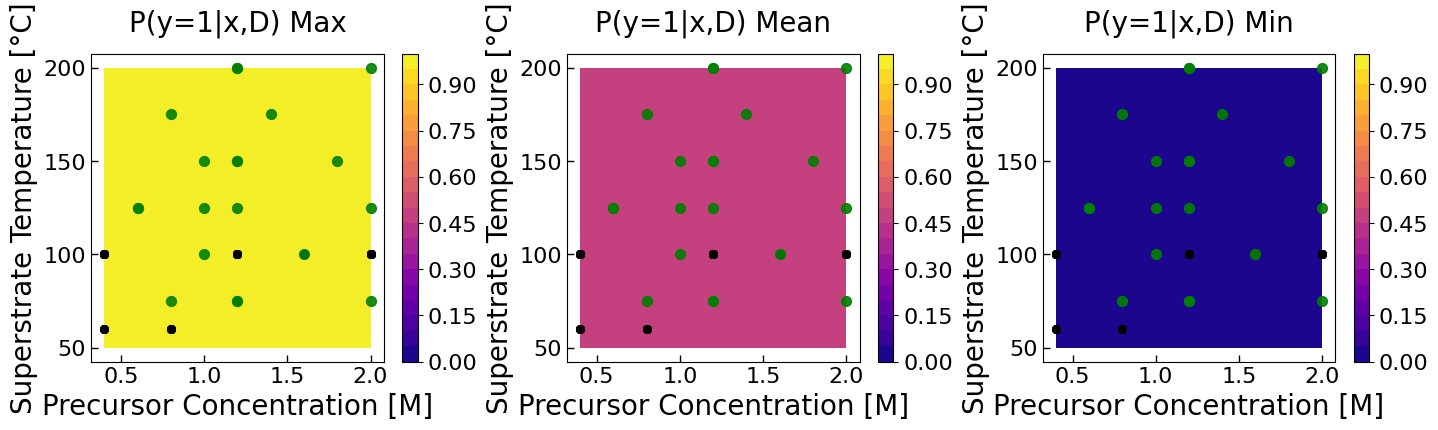

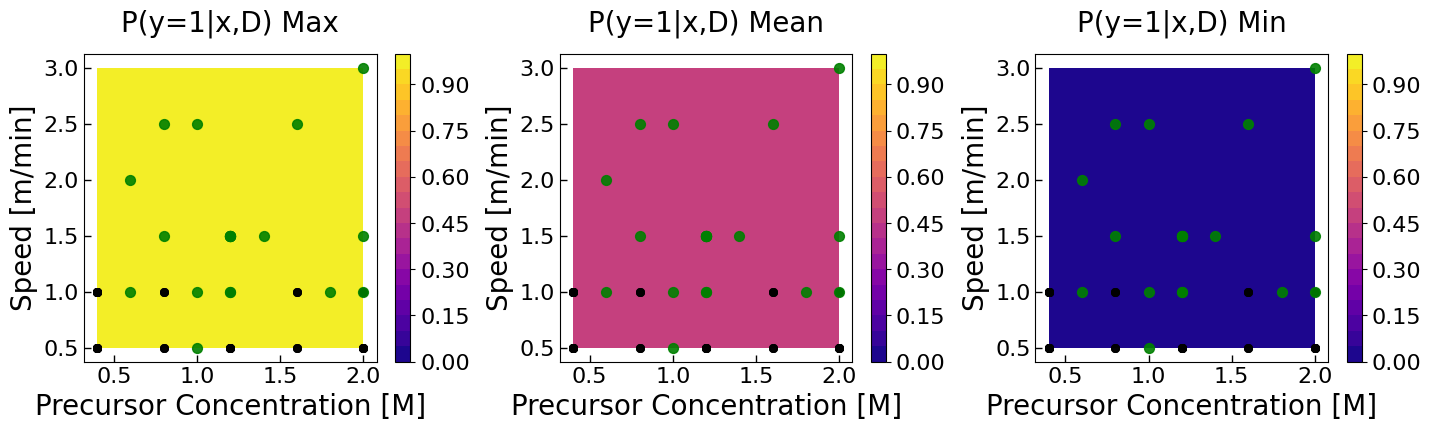

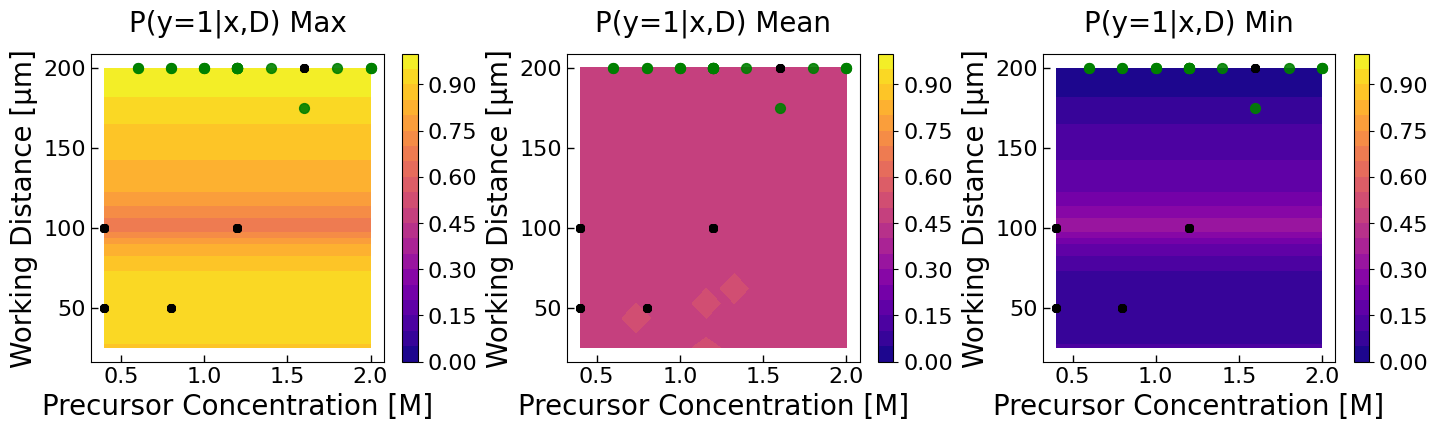

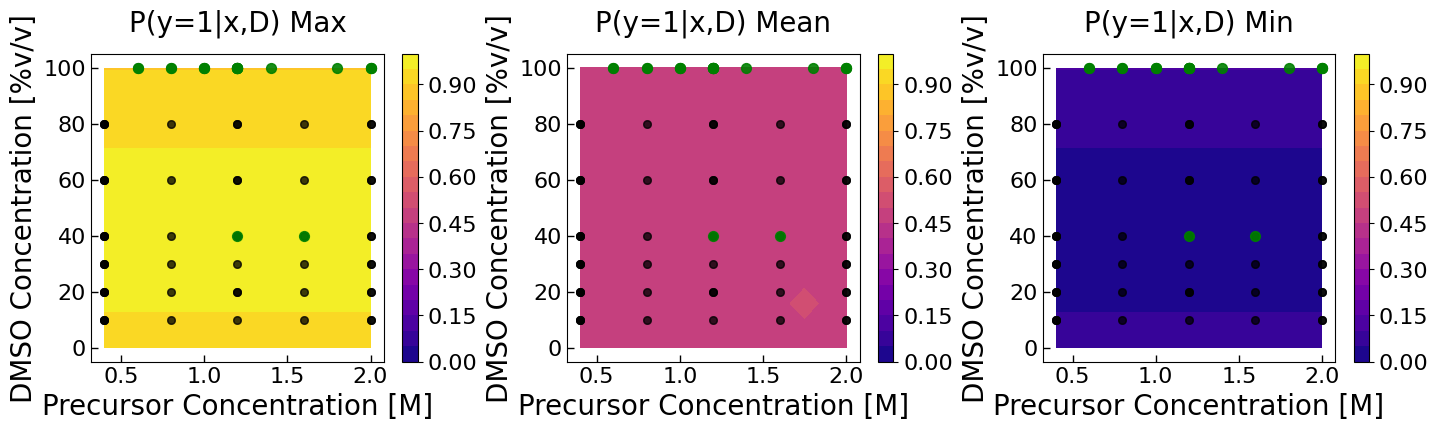

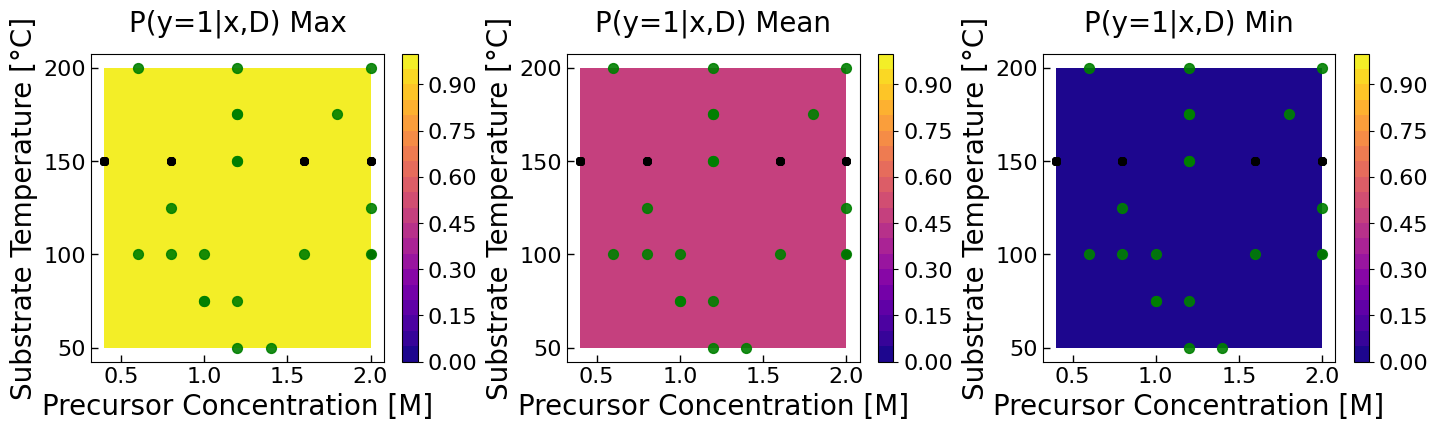

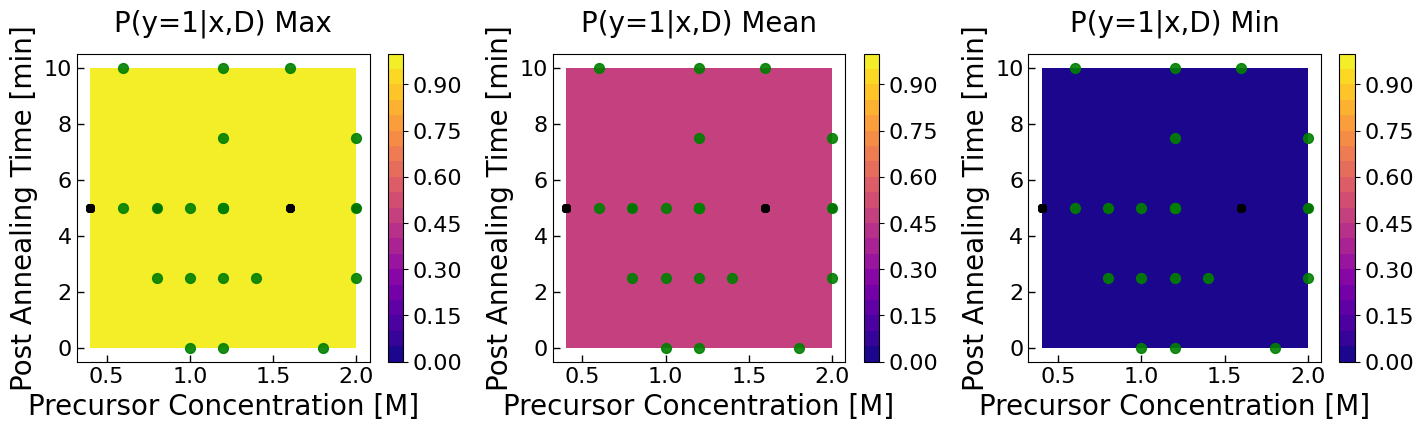

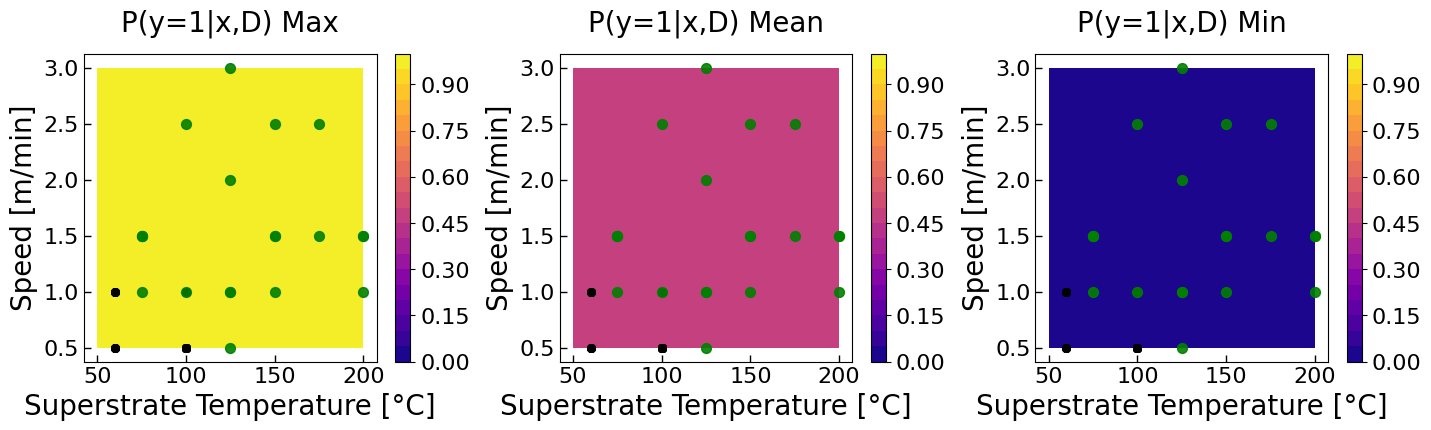

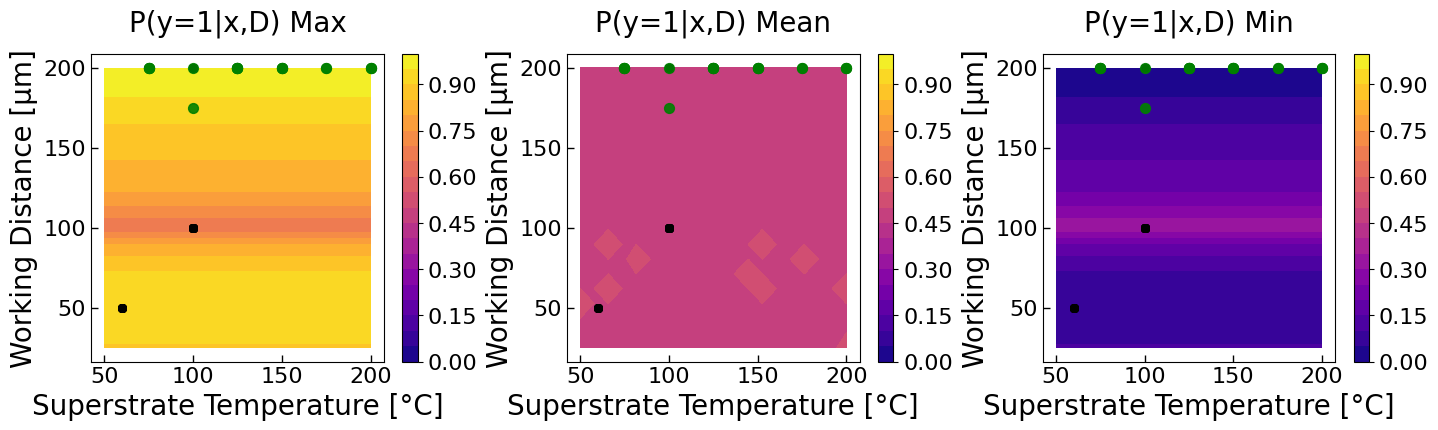

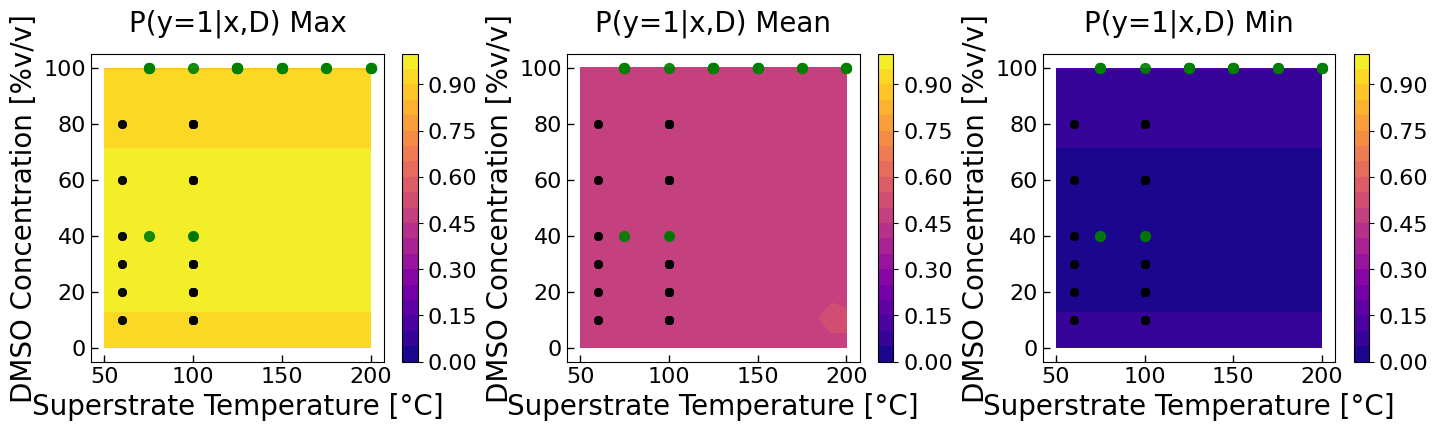

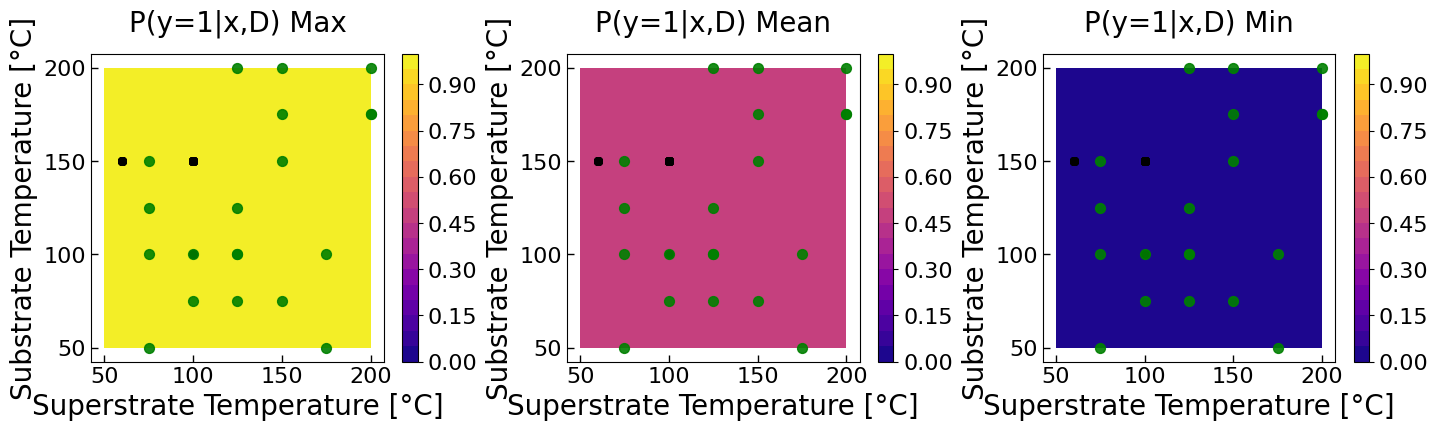

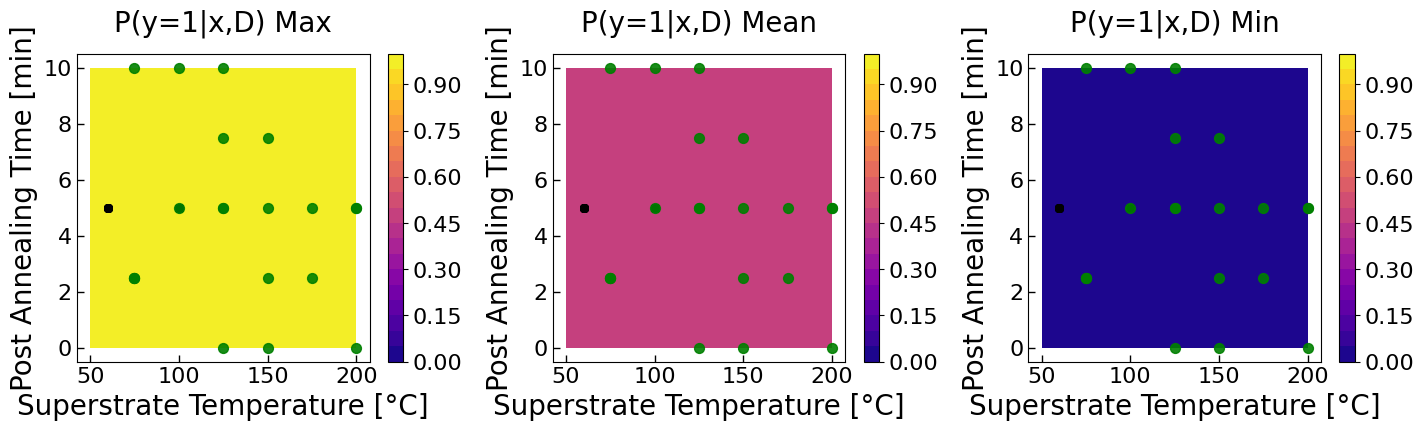

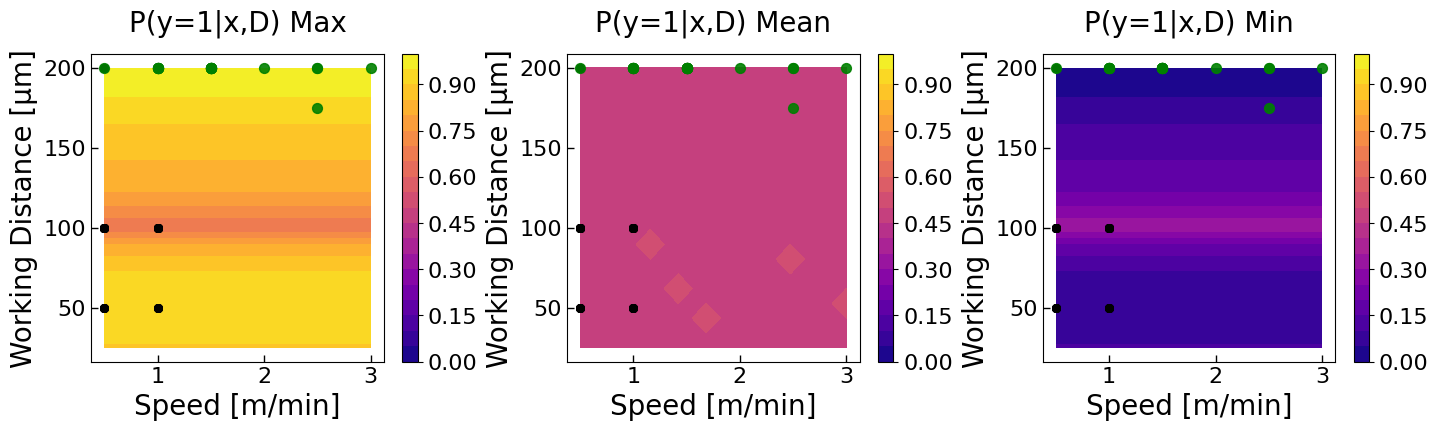

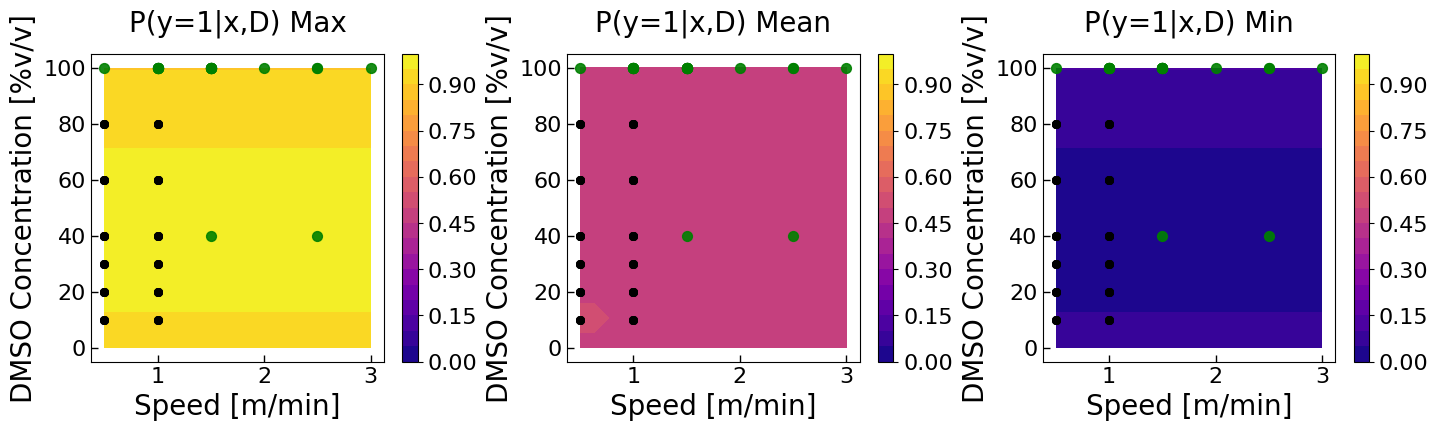

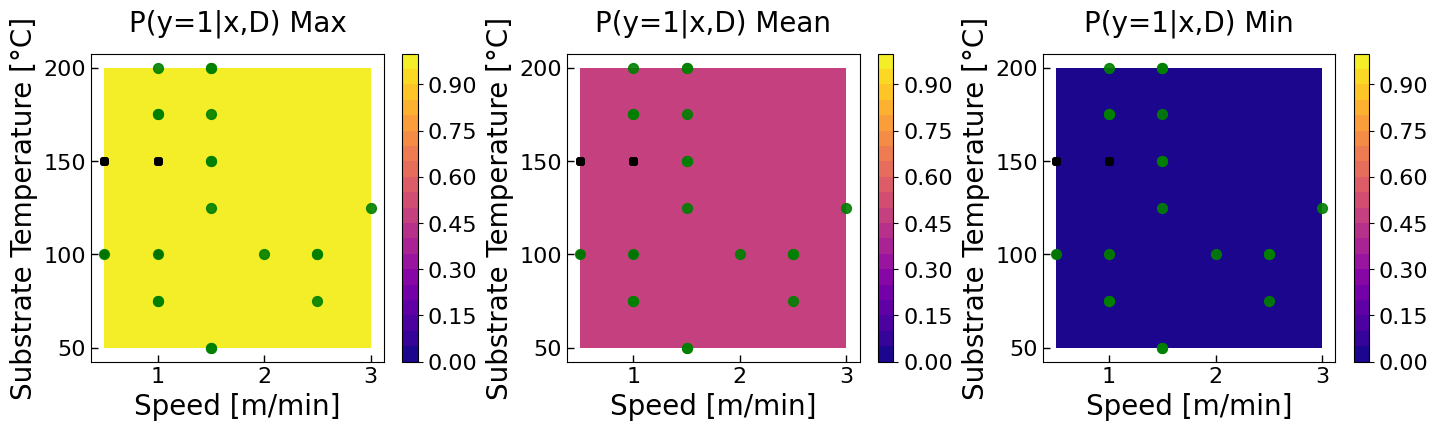

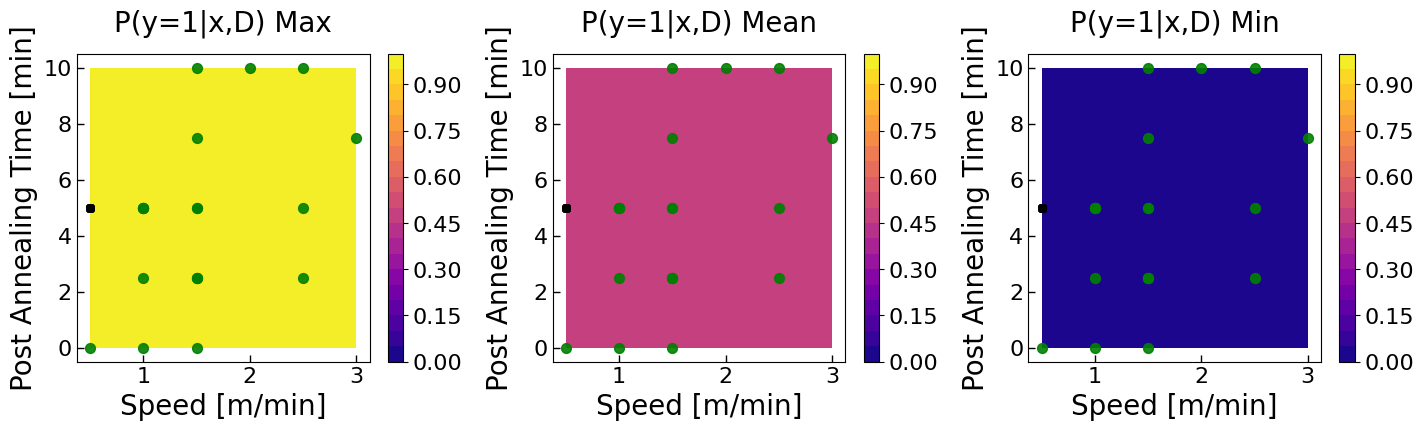

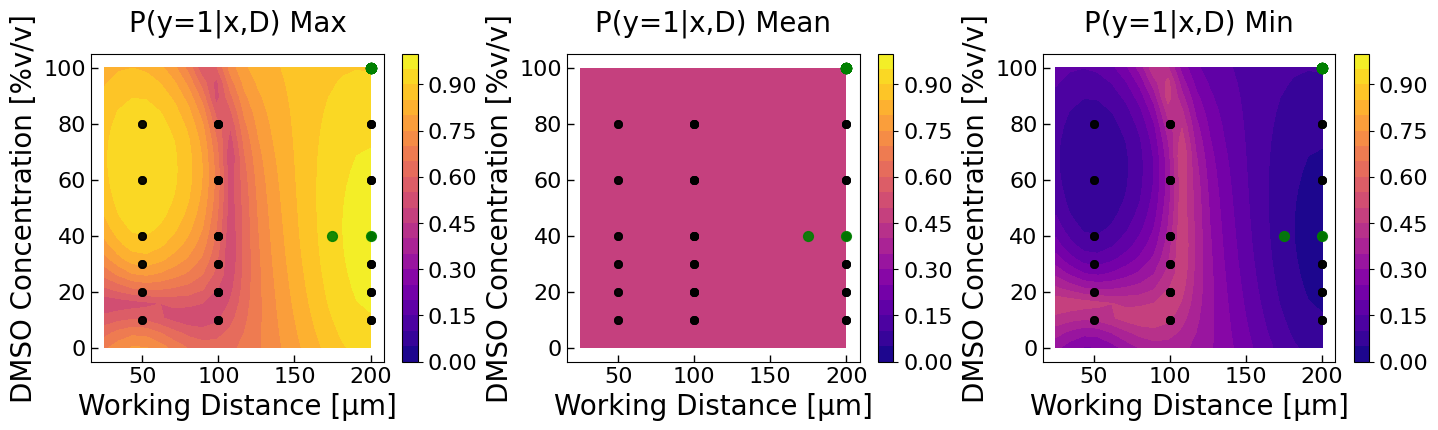

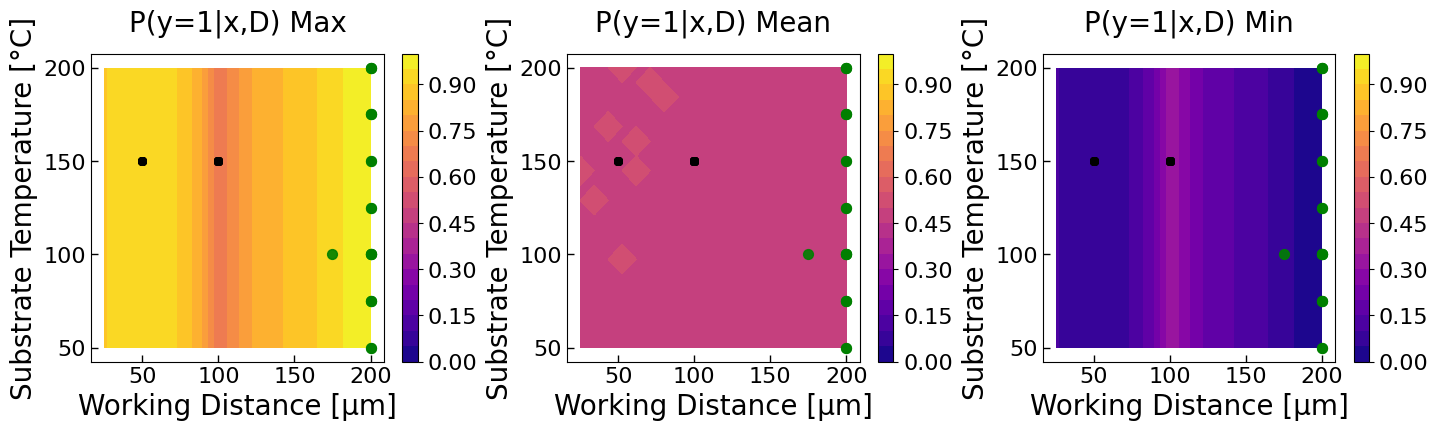

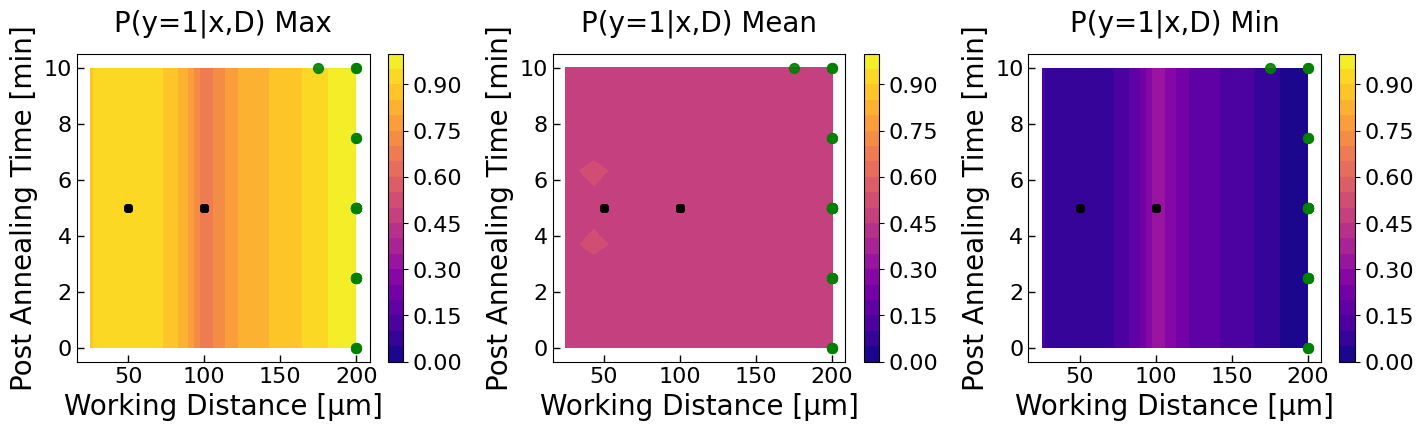

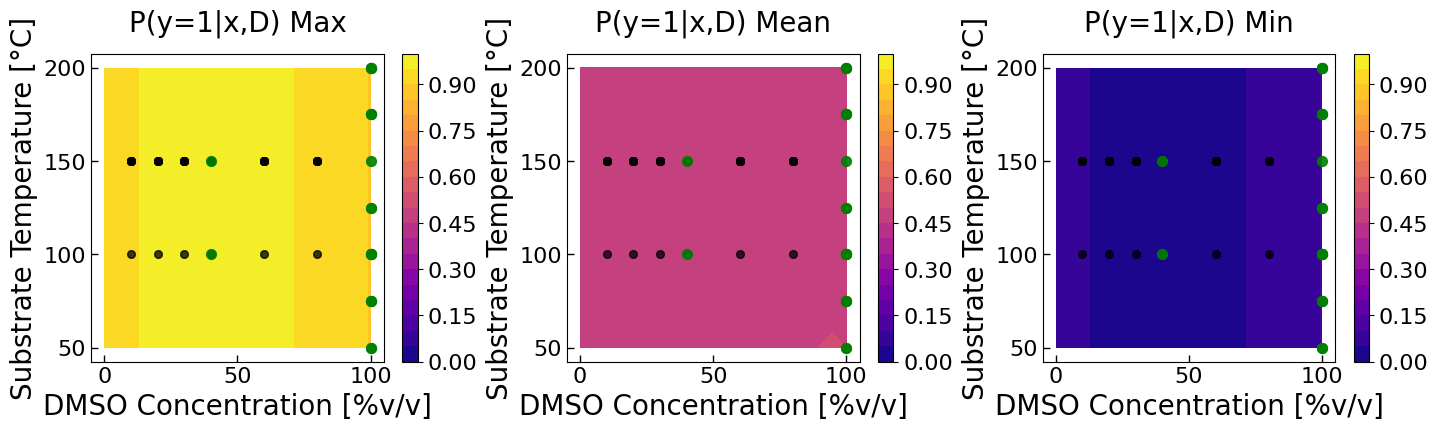

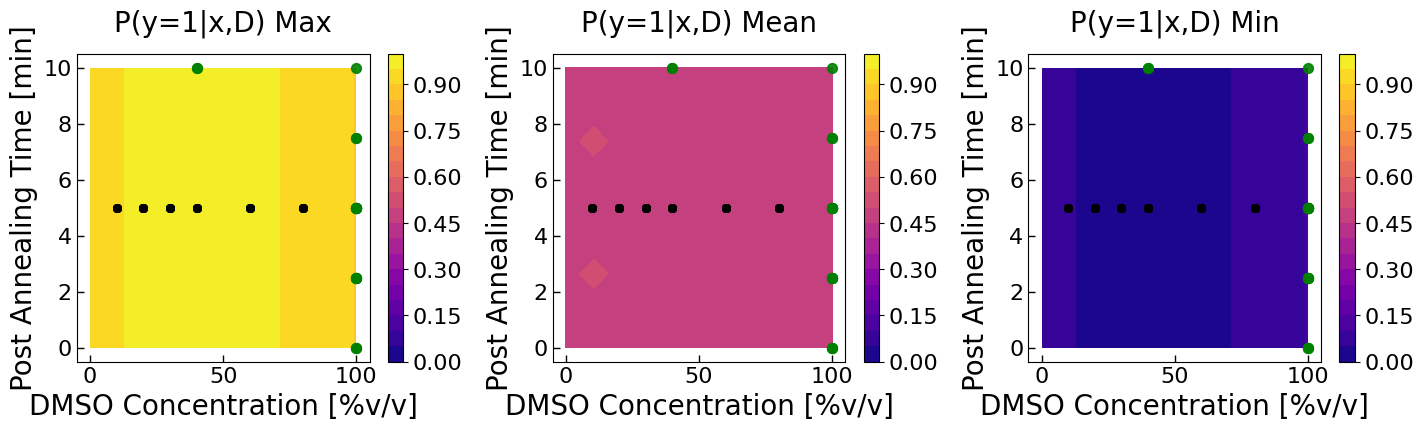

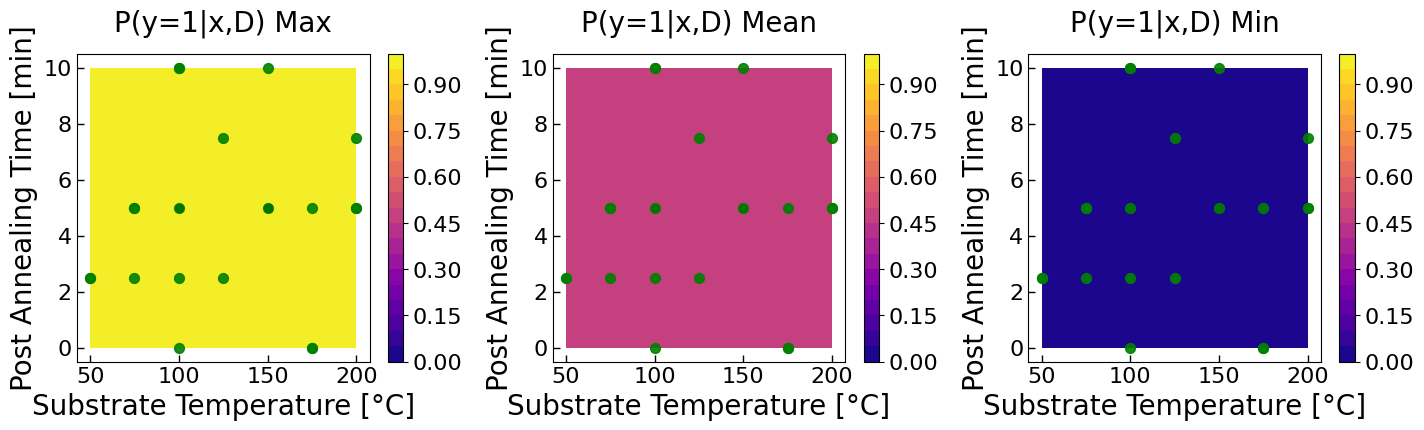

In [ ]:
from emukit.core.initial_designs.random_design import RandomDesign

design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = x_labels
fontsize = 20
title_pad = 16
prior_objective = SklearnGPModel(prior_model)
for i in range(input_dim):
    for j in range(input_dim - i - 1):

        ## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j + i + 1
        n_steps = 20
        x1x2y_pred, x1x2y_uncer = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2
                                
                # f_mu, f_var = objective_model.predict(x_temp)
                p_success = prior_objective.predict_proba(x_temp)
                # p_success = GPy.likelihoods.Bernoulli().gp_link.transf(f_mu)

                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]
                
                x1x2y_pred.append(
                    [x1_org, x2_org, np.max(p_success), np.mean(p_success), np.min(p_success)]
                )
                
        x1 = np.array(x1x2y_pred, dtype=float)[:, 0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=float)[:, 1].reshape(n_steps, n_steps)
        p_max = np.array(x1x2y_pred, dtype=float)[:, 2].reshape(n_steps, n_steps)
        p_mean = np.array(x1x2y_pred, dtype=float)[:, 3].reshape(n_steps, n_steps)
        p_min = np.array(x1x2y_pred, dtype=float)[:, 4].reshape(n_steps, n_steps)

        ## Contour for probability of good film
        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
        
        # print(p_max, p_mean, p_min)
        for ax, y in zip(axes, [p_max, p_mean, p_min]):

            c_plt1 = ax.contourf(
                x1,
                x2,
                y,
                levels=np.linspace(0.0, 1.0, 21),
                cmap="plasma",
                # extend="both",
                # vmin=0,
                # vmax=1
            )
            
            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fontsize * 0.8)
            
            # Plot current conditions
            ax.scatter( 
                x_denormalizer(X)[:, ind1],
                x_denormalizer(X)[:, ind2],
                s=30,
                facecolors="black",
                alpha=0.5,
                edgecolor="black",
            )

            # Plot new conditions
            ax.scatter(
                x_denormalizer(x_new_norm)[:, ind1],
                x_denormalizer(x_new_norm)[:, ind2],
                s=50,
                facecolors="green",
                alpha=0.9,
                edgecolor="green",
            )
            ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

            x1_delta = (np.max(x1) - np.min(x1)) / n_steps
            x2_delta = (np.max(x2) - np.min(x2)) / n_steps
            ax.set_xlim(np.min(x1) - x1_delta, np.max(x1) + x1_delta)
            ax.set_ylim(np.min(x2) - x2_delta, np.max(x2) + x2_delta)
            
            # x1_delta = var_x1[1]- var_x1[0]
            # x2_delta = var_x2[1]- var_x2[0]
    
            # var_x1 = var_array[ind1]
            # var_x2 = var_array[ind2]   
            
            # ax.set_xlim(np.min(var_x1) - x1_delta/n_steps, np.max(var_x1) + x1_delta/n_steps)
            # ax.set_ylim(np.min(var_x2) - x2_delta/n_steps, np.max(var_x2) + x2_delta/n_steps)
            
            # ax.xaxis.set_ticks(np.arange(np.min(var_x1), np.max(var_x1), x1_delta))
            # ax.yaxis.set_ticks(np.arange(np.min(var_x2), np.max(var_x2), x2_delta))

            ax.tick_params(direction="in", length=5, width=1, labelsize=fontsize * 0.8) 
            
        axes[0].set_title("P(y=1|x,D) Max", pad=title_pad, fontsize=fontsize)
        axes[1].set_title("P(y=1|x,D) Mean", pad=title_pad, fontsize=fontsize)
        axes[2].set_title("P(y=1|x,D) Min", pad=title_pad, fontsize=fontsize)

        plt.subplots_adjust(wspace=0.3)
        plt.show()

### Acquisition Functions

##### Original Acquisition Function (based on Objective Function only)

In [ ]:
# design = RandomDesign(parameter_space)
# x_sampled = design.get_samples(200)
# x_columns = df_film.iloc[:, 1:-2].columns
# for i in range(input_dim):
#     for j in range(input_dim - i - 1):
#         ind1 = i
#         ind2 = j + i + 1
#         n_steps = 21
#         x1x2y_pred, x1x2y_var = [[], []]
#         for x1 in np.linspace(0, 1, n_steps):
#             for x2 in np.linspace(0, 1, n_steps):
#                 x_temp = np.copy(x_sampled)
#                 x_temp[:, ind1] = x1
#                 x_temp[:, ind2] = x2
#                 yc_pr = f_raw_acq(x_temp)
#                 x1_org = x_denormalizer(x_temp)[0, ind1]
#                 x2_org = x_denormalizer(x_temp)[0, ind2]
#                 x1x2y_pred.append(
#                     [x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)]
#                 )

#         x1c = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
#         x2c = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)
#         yc_pr_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
#         yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
#         yc_pr_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

#         fontsize = 20
#         title_pad = 16

#         fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
#         colorbar_offset = [0.5, 0.4, 0.3]
#         for ax, y, c_offset in zip(
#             axes, [yc_pr_max, yc_pr_mean, yc_pr_min], colorbar_offset
#         ):
#             c_plt1 = ax.contourf(
#                 x1c,
#                 x2c,
#                 y / 20,
#                 levels=np.arange(10) * 0.05 + c_offset,
#                 cmap="coolwarm",
#                 extend="both",
#             )  #
#             cbar = fig.colorbar(c_plt1, ax=ax)
#             cbar.ax.tick_params(labelsize=fontsize * 0.8)
#             ax.scatter(
#                 x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind1],
#                 x_denormalizer(Xc[Yc[:, -1] == 0])[:, ind2],
#                 s=50,
#                 facecolors="none",
#                 alpha=0.9,
#                 edgecolor="red",
#             )
#             ax.scatter(
#                 x_denormalizer(Xc)[:, ind1],
#                 x_denormalizer(Xc)[:, ind2],
#                 s=30,
#                 facecolors="gray",
#                 alpha=0.5,
#                 edgecolor="gray",
#             )
#             ax.scatter(
#                 x_denormalizer(X_new)[:, ind1],
#                 x_denormalizer(X_new)[:, ind2],
#                 s=50,
#                 facecolors="none",
#                 alpha=0.9,
#                 edgecolor="green",
#             )

#             ax.set_xlabel(str(x_columns[ind1]), fontsize=fontsize)
#             ax.set_ylabel(str(x_columns[ind2]), fontsize=fontsize)

#             x1_delta = (np.max(x1c) - np.min(x1c)) * 0.05
#             x2_delta = (np.max(x2c) - np.min(x2c)) * 0.05
#             ax.set_xlim(np.min(x1c) - x1_delta, np.max(x1c) + x1_delta)
#             ax.set_ylim(np.min(x2c) - x2_delta, np.max(x2c) + x2_delta)
#             ax.tick_params(
#                 direction="in",
#                 length=5,
#                 width=1,
#                 labelsize=fontsize * 0.8,
#                 grid_alpha=0.5,
#             )
#             if ind1 == 0:  # Temp
#                 ax.set_xticks([130, 140, 150, 160, 170])
#             if ind1 == 1:  # Speed
#                 ax.set_xticks([10, 15, 20, 25, 30])
#             if ind1 == 4:  # PlasmaGasFL
#                 ax.set_xticks([15, 20, 25, 30, 35])
#             if ind2 == 5:  # PlasmaDC
#                 ax.set_yticks([25, 50, 75, 100])
#             # axes[i].grid(True, linestyle='-.')

#         axes[0].set_title("orig acqui fcn max", pad=title_pad, fontsize=fontsize)
#         axes[1].set_title("orig prob fcn mean", pad=title_pad, fontsize=fontsize)
#         axes[2].set_title("orig prob fcn min", pad=title_pad, fontsize=fontsize)
#         plt.subplots_adjust(wspace=0.3)
#         plt.show()